In [ ]:
!pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=24d1a071d1af2e79bcf6bc89f0be2db5f8ba27e5b8f27cdaae8bd8bcf64af476
  Stored in directory: /root/.cache/pip/wheels/6a/76/03/7f785aaa50b9c6ec7e3fd105a62c1b2c45a034512d51e024a9
Successfully built ta


In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive

from ta import add_all_ta_features
from ta.utils import dropna
from scipy.stats import mstats

import statistics

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
import torch 
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

from sklearn.model_selection import StratifiedKFold
import copy

import random
random.seed(12345)

#drive.mount('/content/gdrive')

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


#### Upload your files to a drive to be able to read them

In [2]:
with open("/content/gdrive/MyDrive/stock market/training_set.pkl", 'rb') as f:
  data_train = pickle.load(f)


with open("/content/gdrive/MyDrive/stock market/testing_set1.pkl", 'rb') as f:
  data_test1 = pickle.load(f)


with open("/content/gdrive/MyDrive/stock market/testing_set2.pkl", 'rb') as f:
  data_test2 = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gdrive/MyDrive/stock market/training_set.pkl'

### For now i'm reading from my local

In [2]:
with open("training_set.pkl", 'rb') as f:
  data_train = pickle.load(f)


with open("testing_set1.pkl", 'rb') as f:
  data_test1 = pickle.load(f)


with open("testing_set2.pkl", 'rb') as f:
  data_test2 = pickle.load(f)

In [3]:
# Concating all dataframes in the train with the index number as keys
df_train = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_train)])

### Task 1

#### Calculating the pct change : which is the percentage change in the stock's closing price from the prev day's close

In [4]:
df_train['pct_ch_close'] = (df_train.groupby('key')['Close']
                                  .apply(pd.Series.pct_change))
df_train.dropna(inplace=True)

#### Calculating the threshold for decrease/ no-big change/ increase in pct_change using the quantile function

In [5]:
df_train['pct_ch_close'].quantile([.66,0.33]).reset_index()

,index,pct_ch_close
0,0.66,0.001876
1,0.33,-0.002165


In [6]:
df_percentiles = df_train['pct_ch_close'].quantile([.66,0.33]).reset_index()
#df_percentiles = pd.pivot(df_percentiles, columns='index', values='pct_ch_close').reset_index()
df_percentiles = pd.DataFrame([df_percentiles['pct_ch_close']])
df_percentiles.columns = ['0.66','0.33']
df_percentiles

,0.66,0.33
pct_ch_close,0.001876,-0.002165


#### Joining back to the data table to classiffy pct_ch_close in three categories

In [7]:
df_train_w_percentile = df_train
df_train_w_percentile['0.66'] = df_percentiles['0.66'].values[0]
df_train_w_percentile['0.33'] = df_percentiles['0.33'].values[0]
df_train_w_percentile['change'] = 'no big change'
df_train_w_percentile.loc[df_train_w_percentile.pct_ch_close<df_train_w_percentile['0.33'],'change'] = 'decrease'
df_train_w_percentile.loc[df_train_w_percentile.pct_ch_close>df_train_w_percentile['0.66'],'change'] = 'increase'
df_train_w_percentile

,Open,High,Low,Close,Volume,key,pct_ch_close,0.66,0.33,change
1,0.672106,0.674597,0.670546,0.672106,0.208023,0,0.000207,0.001876,-0.002165,no big change
2,0.672106,0.678621,0.671827,0.676282,0.142405,0,0.006214,0.001876,-0.002165,increase
3,0.676338,0.677340,0.672384,0.673498,0.146400,0,-0.004117,0.001876,-0.002165,decrease
4,0.673442,0.676004,0.672997,0.675892,0.116960,0,0.003555,0.001876,-0.002165,increase
5,0.675892,0.676115,0.673609,0.674890,0.205266,0,-0.001483,0.001876,-0.002165,no big change
...,...,...,...,...,...,...,...,...,...,...
2197,0.190271,0.192919,0.185970,0.186300,0.152329,1999,-0.021720,0.001876,-0.002165,decrease
2198,0.186300,0.186631,0.183322,0.183984,0.084532,1999,-0.012433,0.001876,-0.002165,decrease
2199,0.183984,0.184977,0.180675,0.181502,0.074575,1999,-0.013489,0.001876,-0.002165,decrease
2200,0.181502,0.182164,0.177697,0.179021,0.140368,1999,-0.013674,0.001876,-0.002165,decrease


#### Showing the thresholds and the number of datapoints per class

In [8]:
# Here in the below table, the key column represents each stock, the 0.33 column is the upper bound for 'decrease' class, while the 0.66 is the lower bound for the 'increase' class
df_percentiles.head()

,0.66,0.33
pct_ch_close,0.001876,-0.002165


In [9]:
df_counts = df_train_w_percentile[['change']].groupby(['change']).size().reset_index()
df_counts['key'] = 'All'
df_counts = pd.pivot(df_counts, index='key', columns='change', values=0).reset_index()
df_counts.columns = ['key','decrease count','increase count','no big change count']
df_counts

,key,decrease count,increase count,no big change count
0,All,1452658,1496660,1452682


After making the buckets, we've been able to divide the dataset into three classes with roughly equal number of datapoints (~726-748)

### Task 2

#### Creating features
We define a function which takes a dataframe as input and then creates a set of features based on OHLC data (only considering the last 100 rows)

In [10]:
def create_feature_set(df):

  # our first set of features would be the deviation of open/high/low/close price from their historical medians
  df['Open_dev'] = df['Open'] - np.median(df['Open'])
  df['High_dev'] = df['High'] - np.median(df['High'])
  df['Low_dev'] = df['Low'] - np.median(df['Low'])
  df['Close_dev'] = df['Close'] - np.median(df['Close'])

  # next we include some standard statistical measures (range/stdev) against each of the OHLC metric
  df['Open_range'] = max(df["Open"]) - max(df["Open"])
  df['Open_std'] = statistics.stdev(df["Open"])

  df['High_range'] = max(df["High"]) - max(df["High"])
  df['High_std'] = statistics.stdev(df["High"])

  df['Low_range'] = max(df["Low"]) - max(df["Low"])
  df['Low_std'] = statistics.stdev(df["Low"])

  df['Close_range'] = max(df["Close"]) - max(df["Close"])
  df['Close_std'] = statistics.stdev(df["Close"])

  # we now add features between the difference of open and close, open and high, open and low, high and low, high and close, low and close
  df['Open_Close'] = df['Open'] - df['Close']
  df['Open_High'] = df['Open'] - df['High']
  df['Open_Low'] = df['Open'] - df['Low']
  df["High_Close"] = df['High'] - df['Close']
  df['High_Low'] = df['High'] - df['Low']
  df['Low_Close'] = df['Low'] - df['Close']

  # we will now add a few financial indicators using the 'ta' package
  df = add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
  
  df = df[[
      'key','Open', 'High', 'Low', 'Close', 'Volume', 'Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','Open_std','High_range','High_std','Low_range','Low_std','Close_range','Close_std',
      'Open_Close','Open_High','Open_Low','High_Close','High_Low','Low_Close',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr','change'
  ]]
  
  return df


In [11]:
def get_features_last_100(df):
  df_output = pd.DataFrame()
  #print (123)
  for i in range(100,len(df)):
    #print(i)
    df_temp = create_feature_set(df.loc[i-99:i,:])
    df_output.append(df_temp.tail(1))
  df_output


In the below output, we see how the feature set looks like for the first stock (last five rows), the last column is our dependent variable

In [12]:
df_train_w_percentile[df_train_w_percentile.key.isin([0])].groupby('key').apply(lambda grp: create_feature_set(grp)).tail()

,key,Open,High,Low,Close,Volume,Open_dev,High_dev,Low_dev,Close_dev,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,change
2197,0,0.680849,0.683633,0.672997,0.674055,0.351048,-0.109595,-0.109846,-0.113326,-0.116333,...,-0.325075,0.436471,1.755036,4.373958,-2.618922,0.671096,-1.014064,-1.019241,0.289998,decrease
2198,0,0.674389,0.674890,0.671326,0.674055,0.143069,-0.116055,-0.118589,-0.114997,-0.116333,...,-0.234243,0.363327,-3.791546,2.740857,-6.532403,0.671359,0.000000,0.000000,0.289998,no big change
2199,0,0.674110,0.676227,0.672440,0.676004,0.312048,-0.116333,-0.117252,-0.113883,-0.114384,...,-0.154480,0.319055,-4.651307,1.262424,-5.913731,0.671891,0.289159,0.288742,0.579996,increase
2200,0,0.675725,0.675837,0.668820,0.669321,0.279230,-0.114719,-0.117642,-0.117503,-0.121067,...,-0.101340,0.212561,-6.048075,-0.199676,-5.848399,0.671808,-0.988547,-0.993465,-0.414285,decrease
2201,0,0.669293,0.671326,0.662973,0.664198,0.552933,-0.121151,-0.122153,-0.123350,-0.126190,...,-0.079619,0.086881,-0.997003,-0.359141,-0.637862,0.671383,-0.765460,-0.768404,-1.176573,decrease


We need to generate the features for all of the 2000 stocks, this takes sometime (~45min), thus we've stored the output post this stage as a csv file

In [13]:
df_train_w_features = df_train_w_percentile[df_train_w_percentile.key.isin(range(0,200))].groupby('key').apply(lambda grp: create_feature_set(grp))

Getting the dependent variable by a lead function

In [14]:
df_train_w_features['y'] = df_train_w_features.groupby(['key'])['change'].shift(-1)

In [15]:
# This is for local
df_train_w_features.to_parquet('processed_training_set.parquet',index=False)

In [ ]:
# This for colab
df_tain_w_features.to_parquet('/content/gdrive/MyDrive/stock market/processed_training_set.parquet',index=False)

### Task 3: Training Predictive Models

In [ ]:
# If you want to read from colab, else ignore
df_train_w_features = pd.read_parquet('/content/gdrive/MyDrive/stock market/processed_training_set.parquet')

In [16]:
df_train_w_features

,key,Open,High,Low,Close,Volume,Open_dev,High_dev,Low_dev,Close_dev,...,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,change,y
1,0,0.672106,0.674597,0.670546,0.672106,0.208023,-0.118338,-0.118882,-0.115777,-0.118283,...,0.000000,0.000000,0.000000,0.000000,0.672106,-15.835127,0.000000,0.000000,no big change,increase
2,0,0.672106,0.678621,0.671827,0.676282,0.142405,-0.118338,-0.114858,-0.114496,-0.114106,...,0.039640,-2.576511,-0.515302,-2.061209,0.672141,0.621427,0.619504,0.621427,increase,decrease
3,0,0.676338,0.677340,0.672384,0.673498,0.146400,-0.114106,-0.116139,-0.113939,-0.116890,...,0.035885,-4.502110,-1.312664,-3.189446,0.672153,-0.411726,-0.412576,0.207142,decrease,increase
4,0,0.673442,0.676004,0.672997,0.675892,0.116960,-0.117002,-0.117475,-0.113326,-0.114496,...,0.054180,-7.320689,-2.514269,-4.806420,0.672396,0.355548,0.354918,0.563427,increase,no big change
5,0,0.675892,0.676115,0.673609,0.674890,0.205266,-0.114551,-0.117364,-0.112714,-0.115498,...,0.052997,-5.655461,-3.142507,-2.512954,0.672571,-0.148307,-0.148417,0.414285,no big change,decrease
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,199,0.884484,0.885003,0.881371,0.881544,0.042086,-0.076086,-0.076532,-0.078348,-0.078867,...,0.085642,-19.085130,-6.471100,-12.614030,0.885193,-0.176264,-0.176419,-2.735876,no big change,no big change
2198,199,0.881285,0.882236,0.880160,0.881996,0.008188,-0.079285,-0.079299,-0.079559,-0.078415,...,0.058728,-25.085746,-10.194029,-14.891716,0.885121,0.051207,0.051194,-2.686071,no big change,decrease
2199,199,0.882236,0.882461,0.879815,0.879988,0.020354,-0.078334,-0.079074,-0.079905,-0.080423,...,0.026136,-28.879316,-13.931087,-14.948229,0.885078,-0.227665,-0.227925,-2.907620,decrease,decrease
2200,199,0.879685,0.880005,0.876355,0.876355,0.017706,-0.080885,-0.081530,-0.083364,-0.084055,...,-0.020136,-32.490049,-17.642879,-14.847170,0.884474,-0.412742,-0.413596,-3.308361,decrease,decrease


#### For our dependent variable, we consider increase as positive (1), no change and decrease are considered as negative (0)

In [17]:
df_train_w_features['y_level'] = 0
df_train_w_features.loc[df_train_w_features.y=='increase','y_level'] = 1
df_train_w_features
df_train_w_features['index'] = df_train_w_features.index

In [18]:
x_cols = ['Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','Open_std','High_range','High_std','Low_range','Low_std','Close_range','Close_std',
      'Open_Close','Open_High','Open_Low','High_Close','High_Low','Low_Close',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr'
  ]

y_col = ['y_level']

In [19]:
df_training = df_train_w_features[['key','Open_dev','High_dev','Low_dev','Close_dev',
      'Open_range','Open_std','High_range','High_std','Low_range','Low_std','Close_range','Close_std',
      'Open_Close','Open_High','Open_Low','High_Close','High_Low','Low_Close',
       'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_rsi', 'momentum_stoch_rsi',
       'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'momentum_roc', 'momentum_ppo', 'momentum_ppo_signal',
       'momentum_ppo_hist', 'momentum_pvo', 'momentum_pvo_signal',
       'momentum_pvo_hist', 'momentum_kama', 'others_dr', 'others_dlr',
       'others_cr','y_level']]

In [20]:
df_training

,key,Open_dev,High_dev,Low_dev,Close_dev,Open_range,Open_std,High_range,High_std,Low_range,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,y_level
1,0,-0.118338,-0.118882,-0.115777,-0.118283,0.0,0.084605,0.0,0.084585,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.672106,-15.835127,0.000000,0.000000,1
2,0,-0.118338,-0.114858,-0.114496,-0.114106,0.0,0.084605,0.0,0.084585,0.0,...,0.009910,0.039640,-2.576511,-0.515302,-2.061209,0.672141,0.621427,0.619504,0.621427,0
3,0,-0.114106,-0.116139,-0.113939,-0.116890,0.0,0.084605,0.0,0.084585,0.0,...,0.018881,0.035885,-4.502110,-1.312664,-3.189446,0.672153,-0.411726,-0.412576,0.207142,1
4,0,-0.117002,-0.117475,-0.113326,-0.114496,0.0,0.084605,0.0,0.084585,0.0,...,0.032426,0.054180,-7.320689,-2.514269,-4.806420,0.672396,0.355548,0.354918,0.563427,0
5,0,-0.114551,-0.117364,-0.112714,-0.115498,0.0,0.084605,0.0,0.084585,0.0,...,0.045676,0.052997,-5.655461,-3.142507,-2.512954,0.672571,-0.148307,-0.148417,0.414285,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,199,-0.076086,-0.076532,-0.078348,-0.078867,0.0,0.027019,0.0,0.026785,0.0,...,-0.219329,0.085642,-19.085130,-6.471100,-12.614030,0.885193,-0.176264,-0.176419,-2.735876,0
2198,199,-0.079285,-0.079299,-0.079559,-0.078415,0.0,0.027019,0.0,0.026785,0.0,...,-0.204647,0.058728,-25.085746,-10.194029,-14.891716,0.885121,0.051207,0.051194,-2.686071,0
2199,199,-0.078334,-0.079074,-0.079905,-0.080423,0.0,0.027019,0.0,0.026785,0.0,...,-0.198113,0.026136,-28.879316,-13.931087,-14.948229,0.885078,-0.227665,-0.227925,-2.907620,0
2200,199,-0.080885,-0.081530,-0.083364,-0.084055,0.0,0.027019,0.0,0.026785,0.0,...,-0.203147,-0.020136,-32.490049,-17.642879,-14.847170,0.884474,-0.412742,-0.413596,-3.308361,0


#### We create a function which passes the data in a rolling manner with the last 100 rows and labels together

In [21]:
df_training_roll = pd.DataFrame()
for i in df_training.key.unique():
    df_training_temp = pd.DataFrame()
    df_temp = df_training[df_training.key==i].reset_index()
    df_training_x = df_temp[x_cols]
    x_lists = []
    y_list = []
    for j in range(100,len(df_temp)):
        x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
        #print ()
        y_list.append(df_temp.loc[j,'y_level'])

    df_training_temp['x'] = x_lists
    df_training_temp['y'] = y_list
    df_training_temp['key'] = i

    df_training_roll = df_training_roll.append(df_training_temp)
    
df_training_roll = df_training_roll.reset_index()
df_training_roll = df_training_roll[['key','x','y']]
df_training_roll['index'] = df_training_roll.index

In [22]:
df_training_roll.head()

,key,x,y,index
0,0,"[[-0.11833824766533829, -0.11485771096929887, ...",0,0
1,0,"[[-0.11410594563360899, -0.11613856716773019, ...",0,1
2,0,"[[-0.11700173347042486, -0.11747508136264373, ...",0,2
3,0,"[[-0.11455142204056667, -0.11736368039563905, ...",0,3
4,0,"[[-0.11544245982852241, -0.11780919928961697, ...",0,4


In [23]:
validation_index = df_training_roll.groupby(['key']).apply(lambda x: x.sample(frac=0.33)).reset_index(drop=True)['index']

In [24]:
data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

In [25]:
data_train

,key,x,y
1,0,"[[-0.11410594563360899, -0.11613856716773019, ...",0
5,0,"[[-0.10825862698945476, -0.09263797659814921, ...",0
6,0,"[[-0.10210501941656824, -0.10294035672102164, ...",1
7,0,"[[-0.10174307249135395, -0.1038870525054596, -...",0
8,0,"[[-0.10355293457848636, -0.10416551243595074, ...",1
...,...,...,...
420195,199,"[[-0.041840932686516896, -0.039692868675555326...",0
420196,199,"[[-0.0399765017974647, -0.040211708143034985, ...",0
420197,199,"[[-0.03855477345505387, -0.03951987820203917, ...",0
420198,199,"[[-0.040597406963849614, -0.04142237755151046,...",0


#### At first we train some SVC, Random Forest based models. 
These take in 1-d data as input, we thus have to flatten our data to fit into a 1d framework. For the SVC models we use the balanced class weight argument to ensure that the data is balanced

In [26]:
def flatten_array_simple(arr_in,lookback = 1,max_num=100):
    arr_out = []
    for i in range(lookback):
        #print (arr_in,i,max_num)
        arr_temp = arr_in[max_num-i-1]
        arr_out.extend(arr_temp)
    return arr_out

def flatten_array_max(arr_in,max_num=100):
    arr_out = []
    arr_out = arr_in[max_num-1]
    arr_out_2 = np.max(arr_in[:max_num],axis=0)
    arr_out.extend(arr_out_2)
    return arr_out

def get_output_params(y_pred,y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    positive_share = sum(y_pred)/len(y_pred)

    return [accuracy,precision,positive_share]

In [73]:
def basic_classifiers_flatten(data_train,data_test,type = 'none',lookback = 100,hyperparameter_tune = True,fraction=0.01):  

    '''
    inputs 

    data_train - training data
    data_test - testing data
    type - type of flattening to be done,
        none : no flattening only take last row
        simple : just extend feature set adding in lagged terms
        max : take latest obs as it is and the max for each column in past
    lookback - number of historical rows to take into account

    output

    parameters related to different models trained
    '''

    ## taking 10% sample to increase training time
    data_train = data_train.groupby(['y']).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
    data_test = data_test.sample(frac=0.01)

    if type=='none':
        
        x_train = [flatten_array_simple(a) for a in data_train['x']]
        #print (1)
        x_test = [flatten_array_simple(a) for a in data_test['x']]

        y_train = data_train['y']
        y_test = data_test['y']
    elif type == 'simple':
        x_train = flatten_array_simple(data_train['x'],lookback=lookback)
        x_test = flatten_array_simple(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']
    else:
        x_train = flatten_array_max(data_train['x'],lookback=lookback)
        x_test = flatten_array_max(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']

    output_list = []


    param_grid_lr = {
        'penalty' : ['l1','l2', 'elasticnet', None],
        'C' : [1,0.1,0.01],
        'class_weight': ['balanced']

    }
    
    
    #svc_model = SVC(random_state=0, tol=1e-5,class_weight='balanced')
    param_grid_svm = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf'],
              'class_weight':['balanced']} 
    
    param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy'],
              'class_weight' : ['balanced']
             }
    
    param_grid_rf = {
    'n_estimators': [25, 50, 100],
    'max_features': ['sqrt', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9],
    'class_weight' : ['balanced']
            }
    
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

    if (hyperparameter_tune):
        lr_model  = GridSearchCV(LogisticRegression(), param_grid_lr, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')
        svc_model = GridSearchCV(SVC(), param_grid_svm, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')
        dt_model = GridSearchCV(tree.DecisionTreeClassifier(), param_grid_dt, refit = True,n_jobs=-1,cv=cv, verbose = 0,scoring='precision')
        rf_model = GridSearchCV(RandomForestClassifier(), param_grid_rf, refit = True,n_jobs=-1,cv=cv, verbose = 3,scoring='precision')

    
    else:
        lr_model = LogisticRegression(class_weight='balanced')
        svc_model = SVC(class_weight='balanced')
        dt_model = tree.DecisionTreeClassifier(class_weight='balanced')
        rf_model = RandomForestClassifier(class_weight='balanced')

    
    lr_model.fit(x_train, y_train)
    y_pred_lr = lr_model.predict(x_test)
    y_pred_lr_train = lr_model.predict(x_train) 
    lr_output_temp = get_output_params(y_pred_lr,y_test).extend(get_output_params(y_pred_lr_train,y_train))
    lr_output =  (get_output_params(y_pred_lr,y_test))
    lr_output.extend(get_output_params(y_pred_lr_train,y_train))
    output_list.append(lr_output)

    svc_model.fit(x_train, y_train)
    y_pred_svc = svc_model.predict(x_test) 
    y_pred_svc_train = svc_model.predict(x_train) 
    svc_output_temp = get_output_params(y_pred_svc,y_test)
    svc_output_temp.extend(get_output_params(y_pred_svc_train,y_train))
    output_list.append(svc_output_temp)
    #print (svc_model.get)
    
    dt_model.fit(x_train,y_train)
    y_pred_dt_model = dt_model.predict(x_test)
    y_pred_dt_train = dt_model.predict(x_train) 
    dt_output_temp = get_output_params(y_pred_dt_model,y_test)
    dt_output_temp.extend(get_output_params(y_pred_dt_train,y_train))
    output_list.append(dt_output_temp)

    
    rf_model.fit(x_train,y_train)
    y_pred_rf_model = rf_model.predict(x_test)
    y_pred_rf_train = rf_model.predict(x_train) 
    rf_output_temp = get_output_params(y_pred_rf_model,y_test)
    rf_output_temp.extend(get_output_params(y_pred_rf_train,y_train))
    output_list.append(rf_output_temp)
    #print (output_list)
    df_output = pd.DataFrame(output_list)
    #print (df_output)
    df_output.columns = [
        'Test_accuracy','Test_precision','Test_pos_share',
        'Train_accuracy','Train_precision','Train_pos_share'
    ]
    # df_output.columns = ['accuracy_score','precision_score','positive_share']
    df_output['Model'] = ['lr','svc','dt','random_forest']

    df_output = df_output[['Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    
    return (df_output)

In [84]:
df_output = pd.DataFrame()
for i in tqdm(data_train.key.unique()[0:21]):
    df_temp = basic_classifiers_flatten(data_train[data_train.key==i],data_test[data_test.key==i],fraction=0.01)
    df_temp['key'] = i
    df_output = df_output.append(df_temp)

  0%|          | 0/21 [00:00<?, ?it/s]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


  5%|▍         | 1/21 [00:15<05:12, 15.61s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 10%|▉         | 2/21 [00:33<05:21, 16.94s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 14%|█▍        | 3/21 [00:55<05:46, 19.24s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 19%|█▉        | 4/21 [01:17<05:48, 20.49s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 24%|██▍       | 5/21 [01:40<05:41, 21.35s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 29%|██▊       | 6/21 [01:55<04:49, 19.27s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 33%|███▎      | 7/21 [02:17<04:40, 20.03s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 38%|███▊      | 8/21 [02:35<04:09, 19.20s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 43%|████▎     | 9/21 [02:58<04:06, 20.58s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 48%|████▊     | 10/21 [03:17<03:40, 20.03s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 52%|█████▏    | 11/21 [03:42<03:36, 21.67s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 57%|█████▋    | 12/21 [04:00<03:03, 20.35s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 62%|██████▏   | 13/21 [04:23<02:49, 21.14s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 67%|██████▋   | 14/21 [04:43<02:26, 20.99s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 71%|███████▏  | 15/21 [05:07<02:10, 21.73s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 76%|███████▌  | 16/21 [05:23<01:40, 20.07s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 81%|████████  | 17/21 [05:46<01:23, 20.85s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 86%|████████▌ | 18/21 [06:04<01:00, 20.17s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 90%|█████████ | 19/21 [06:26<00:41, 20.77s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 95%|█████████▌| 20/21 [06:41<00:19, 19.06s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


100%|██████████| 21/21 [07:07<00:00, 20.34s/it]


In [85]:
## showing aggregated performance for all models
df_basic_models = df_output.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

In [86]:
df_basic_models

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,key
3,svc,0.321429,0.285714,0.642857,0.571429,0.000000,0.000000,10.0
0,dt,1.000000,0.400000,1.000000,0.571429,0.357143,0.285714,10.0
2,random_forest,1.000000,0.450000,1.000000,0.571429,0.357143,0.285714,10.0
1,lr,1.000000,0.583333,1.000000,0.571429,0.357143,0.285714,10.0


In [52]:
import pdb

In [78]:
try_train = data_train[data_train.key==2]
try_test = data_test[data_test.key==2]

train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.06)).reset_index(drop=True)
test_try = try_test.sample(frac=0.1)

x_train = [flatten_array_simple(a) for a in try_train['x']]
#print (1)
x_test = [flatten_array_simple(a) for a in try_test['x']]

y_train = try_train['y']
y_test = try_test['y']

encoder = LabelEncoder()
encoder.fit(y_train)
y = encoder.transform(y_train)

X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)

In [79]:
# Define two models
class Wide_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(104, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(104, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(104, 200)
        self.relu = nn.ReLU()
        self.output = nn.Linear(200, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(104, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

class Deep_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(104, 30)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(104, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 

In [80]:
# Compare model sizes
model_w1 = Wide_1()
model_w2 = Wide_2()
model_w3 = Wide_3()
model_d1 = Deep_1()
model_d2 = Deep_2()
model_d3 = Deep_3()
 
# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
 
    n_epochs = 30   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)
 
    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_pres = - np.inf
    best_weights = None
 
    for epoch in range(n_epochs):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_val)
        acc = (y_pred.round() == y_val).float().mean()
        acc = float(acc)
        #print (y_pred.round().detach().numpy())
        pres = precision_score(y_pred.round().detach(), y_val, average='macro')
        share_pos = sum(y_pred.round().detach())/len(y_pred.round().detach())
        if pres > best_pres:
            best_pres = pres
            #print (best_pres)
            best_weights = copy.deepcopy(model.state_dict())
            best_acc = acc
    # restore model and return best accuracy
    model.load_state_dict(best_weights)

    y_train_pred = model(X_train).round().detach()
    y_test_pred = model(X_val).round().detach()

    pres_train = precision_score(y_train_pred,y_train, average = 'macro')
    pres_test = precision_score(y_test_pred,y_val, average = 'macro')

    acc_train = accuracy_score(y_train_pred,y_train)
    acc_test = accuracy_score(y_test_pred,y_val)

    share_pos_train = sum(y_train_pred.round().detach())/len(y_train_pred.round().detach())
    share_pos_test = sum(y_test_pred.round().detach())/len(y_test_pred.round().detach())


    return pres_train,pres_test,acc_train,acc_test,share_pos_train,share_pos_test
 
 

In [81]:
try_train = df_training_roll[df_training_roll.key==2]

train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

x_train = [flatten_array_simple(a) for a in try_train['x']]

y_train = try_train['y']
y_test = try_test['y']

encoder = LabelEncoder()
encoder.fit(y_train)
y = encoder.transform(y_train)

X = torch.tensor(x_train, dtype=torch.float32)
y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

In [82]:
def nn_preprocess(df_train,key,fraction=0.1):
    try_train = df_train[df_train.key==key]

    train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.1)).reset_index(drop=True)

    x_train = [flatten_array_simple(a) for a in try_train['x']]

    y_train = try_train['y']
    y_test = try_test['y']

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    X = torch.tensor(x_train, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

    return X_train,X_test,y_train,y_test

In [83]:
def get_nn_model_output(df_train,key):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)

    X_train,X_test,y_train,y_test = nn_preprocess(df_train,key)

    pres_scores = []
    acc_scores = []
    pos_share = []

    for i in ([Wide_1(),Wide_2(),Wide_3(),Deep_1(),Deep_2(),Deep_3()]):
        pres_temp = []
        acc_temp = []
        pos_temp = []
        for train, test in kfold.split(X_train, y_train):
            # create model, train, and get accuracy
            model = i
            pres_train,pres_test,acc_train,acc_test,share_pos_train,share_pos_test = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
            #print("Precision: %.2f" % pres)
            pres_temp.append([pres_train,pres_test])
            acc_temp.append([acc_train,acc_test])
            pos_temp.append([share_pos_train,share_pos_test])

            
        pres_scores.append([float(sum(l))/len(l) for l in zip(*pres_temp)])
        acc_scores.append([float(sum(l))/len(l) for l in zip(*acc_temp)])
        pos_share.append([float(sum(l))/len(l) for l in zip(*pos_temp)])

    df_pres = pd.DataFrame(pres_scores)
    df_acc = pd.DataFrame(acc_scores)
    df_share = pd.DataFrame(pos_share)

    df_output = pd.concat([df_pres, df_acc,df_share], axis=1)

    df_output.columns = ['Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']

    df_output['Model'] = ['Wide_1','Wide_2','Wide_3','Deep_1','Deep_2','Deep_3']
    df_output['key'] = key
    df_output = df_output[['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    return (df_output)

In [51]:
df_final_output_nn = pd.DataFrame(columns=['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(df_training_roll.key.unique()[0:21]):
    df_temp = get_nn_model_output(df_training_roll,key=i)
    df_final_output_nn = pd.concat([df_final_output_nn,df_temp])

100%|██████████| 21/21 [42:14<00:00, 120.71s/it]


In [52]:
df_dn_models =df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

In [89]:
df_output_second = df_dn_models.append(df_basic_models.drop(['key'],axis=1))

In [90]:
df_output_second

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share
2,Deep_3,0.537383,0.531356,0.598299,0.601361,0.182313,0.197279
1,Deep_2,0.537646,0.548462,0.621769,0.614286,0.237755,0.253061
5,Wide_3,0.528736,0.550920,0.558163,0.570068,0.380442,0.390476
4,Wide_2,0.526655,0.555035,0.567517,0.574830,0.403742,0.402721
0,Deep_1,0.553555,0.555370,0.607483,0.602041,0.303231,0.297959
3,Wide_1,0.542019,0.561325,0.557483,0.591837,0.405612,0.400680
3,svc,0.321429,0.285714,0.642857,0.571429,0.000000,0.000000
0,dt,1.000000,0.400000,1.000000,0.571429,0.357143,0.285714
2,random_forest,1.000000,0.450000,1.000000,0.571429,0.357143,0.285714
1,lr,1.000000,0.583333,1.000000,0.571429,0.357143,0.285714


### Part 4: feature selection

We will use a few steps for feature selection - 
- Removing variables with high correlation
- using statistical techniques such as rfe and random forest to get top 'n' features
- retraining the models to get updated numbers

In [17]:
import seaborn as sb

In [18]:
df_before_fe = df_train_w_features.drop(['y','change','index'],axis=1)
df_before_fe_numeric = df_before_fe.drop(['y_level','Open_range','High_std','Low_range','Low_std','Close_std','Close_range','Open_std','High_range'],axis=1)

In [19]:
df_corr_raw = df_before_fe_numeric.groupby('key').corr().abs().reset_index()

In [20]:
df_corr_fin = df_corr_raw.drop(['key'],axis=1).fillna(np.inf).groupby('level_1').median().replace(np.inf, np.nan).reset_index()
df_corr_fin.index = df_corr_fin.level_1
df_corr_fin.drop(['level_1'],axis=1,inplace=True)

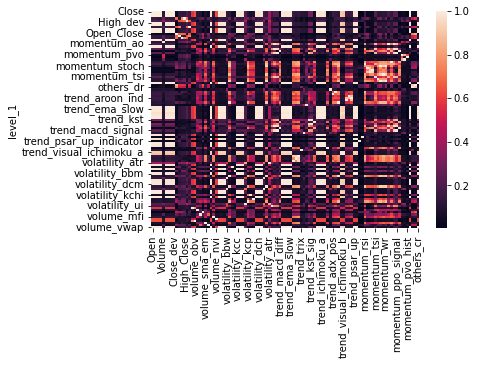

In [21]:
sb.heatmap(df_corr_fin, annot=False)
plt.show()

In [22]:
upper = df_corr_fin.where(np.triu(np.ones(df_corr_fin.shape), k=1).astype(np.bool))

# find features with correlation greater than 0.95

to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [23]:
df_after_corr = df_before_fe.drop(to_drop,axis=1)

In [24]:
df_after_corr.head()

,key,Open,Volume,Open_range,Open_std,High_range,High_std,Low_range,Low_std,Close_range,...,volatility_kcli,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,y_level
1,0,0.672106,0.208023,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,0.602696,0.384934,0.0,0.0,0.000000,0.000000,0.000000,-15.837308,1
2,0,0.672106,0.142405,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197701,0.710345,0.0,0.0,0.059900,0.020548,0.039352,0.001214,0
3,0,0.676338,0.146400,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.198114,0.365517,0.0,0.0,0.097222,0.064446,0.032776,0.002377,1
4,0,0.673442,0.116960,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197256,0.662070,0.0,0.0,0.120528,0.093513,0.027015,0.004147,0
5,0,0.675892,0.205266,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197098,0.537931,0.0,0.0,0.139916,0.108383,0.031533,0.005949,0


In [25]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [27]:
df_after_corr

,key,Open,Volume,Open_range,Open_std,High_range,High_std,Low_range,Low_std,Close_range,...,volatility_kcli,volatility_dcw,volatility_dcp,volatility_atr,volatility_ui,trend_vortex_ind_pos,trend_vortex_ind_neg,trend_vortex_ind_diff,trend_trix,y_level
1,0,0.672106,0.208023,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,0.602696,0.384934,0.000000,0.000000,0.000000,0.000000,0.000000,-15.837308,1
2,0,0.672106,0.142405,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197701,0.710345,0.000000,0.000000,0.059900,0.020548,0.039352,0.001214,0
3,0,0.676338,0.146400,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.198114,0.365517,0.000000,0.000000,0.097222,0.064446,0.032776,0.002377,1
4,0,0.673442,0.116960,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197256,0.662070,0.000000,0.000000,0.120528,0.093513,0.027015,0.004147,0
5,0,0.675892,0.205266,0.0,0.084605,0.0,0.084585,0.0,0.084635,0.0,...,0.0,1.197098,0.537931,0.000000,0.000000,0.139916,0.108383,0.031533,0.005949,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197,199,0.884484,0.042086,0.0,0.027019,0.0,0.026785,0.0,0.027266,0.0,...,1.0,1.583228,0.344143,0.003323,0.703400,1.053675,0.949315,0.104360,-0.033473,0
2198,199,0.881285,0.008188,0.0,0.027019,0.0,0.026785,0.0,0.027266,0.0,...,1.0,1.583279,0.376442,0.003198,0.692919,0.996075,1.019621,-0.023546,-0.030523,0
2199,199,0.882236,0.020354,0.0,0.027019,0.0,0.026785,0.0,0.027266,0.0,...,1.0,1.583245,0.232771,0.003143,0.697880,0.968992,0.998851,-0.029858,-0.028703,0
2200,199,0.879685,0.017706,0.0,0.027019,0.0,0.026785,0.0,0.027266,0.0,...,1.0,1.626319,0.000000,0.003194,0.724022,0.963835,1.046372,-0.082538,-0.028465,0


In [41]:
df_after_corr_trimmed = df_after_corr.sample(frac=0.2)

In [42]:
X = df_after_corr_trimmed.drop(['key','y_level'],axis=1)
y = df_after_corr_trimmed['y_level']

In [43]:
min_features_to_select = 1  # Minimum number of features to consider
clf = tree.DecisionTreeClassifier(class_weight='balanced')
cv = StratifiedKFold(5)

rfecv = RFECV(
    estimator=clf,
    step=2,
    cv=cv,
    scoring="precision",
    min_features_to_select=min_features_to_select,
    n_jobs=5,
)
rfecv.fit(X, y)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 10


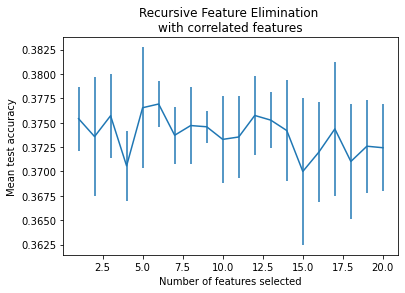

In [44]:
import matplotlib.pyplot as plt

n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [45]:
for i in range(X.shape[1]):
    print('Column: %d, Selected %s, Rank: %.3f' % (i, rfecv.support_[i], rfecv.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected True, Rank: 1.000
Column: 2, Selected False, Rank: 15.000
Column: 3, Selected False, Rank: 11.000
Column: 4, Selected False, Rank: 15.000
Column: 5, Selected False, Rank: 10.000
Column: 6, Selected False, Rank: 14.000
Column: 7, Selected False, Rank: 11.000
Column: 8, Selected False, Rank: 14.000
Column: 9, Selected False, Rank: 10.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 4.000
Column: 12, Selected False, Rank: 8.000
Column: 13, Selected True, Rank: 1.000
Column: 14, Selected False, Rank: 3.000
Column: 15, Selected True, Rank: 1.000
Column: 16, Selected False, Rank: 5.000
Column: 17, Selected True, Rank: 1.000
Column: 18, Selected False, Rank: 3.000
Column: 19, Selected False, Rank: 6.000
Column: 20, Selected True, Rank: 1.000
Column: 21, Selected True, Rank: 1.000
Column: 22, Selected False, Rank: 7.000
Column: 23, Selected False, Rank: 8.000
Column: 24, Selected False, Rank: 13.000
Column: 2

In [51]:
df_feature_summary = pd.DataFrame()
df_feature_summary['columns'] = X.columns
df_feature_summary['selected'] = rfecv.support_
df_feature_summary['rank'] = rfecv.ranking_
df_feature_summary = df_feature_summary.sort_values(by='rank').reset_index()

In [65]:
final_cols = list(df_feature_summary[df_feature_summary.selected]['columns'])
final_cols

['Open',
 'volatility_kcw',
 'volume_nvi',
 'volume_mfi',
 'volume_em',
 'volume_cmf',
 'volume_adi',
 'Open_Close',
 'trend_trix',
 'Volume']

In [66]:
final_cols.extend(['key','y_level'])

In [67]:
df_training_selected_features = df_after_corr[final_cols]

Rolling the datafarme

In [68]:
x_cols = ['Open',
 'volatility_kcw',
 'volume_nvi',
 'volume_mfi',
 'volume_em',
 'volume_cmf',
 'volume_adi',
 'Open_Close',
 'trend_trix',
 'Volume']

In [69]:
df_training_roll = pd.DataFrame()
for i in df_training_selected_features.key.unique():
    df_training_temp = pd.DataFrame()
    df_temp = df_training_selected_features[df_training_selected_features.key==i].reset_index()
    df_training_x = df_temp[x_cols]
    x_lists = []
    y_list = []
    for j in range(100,len(df_temp)):
        x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
        #print ()
        y_list.append(df_temp.loc[j,'y_level'])

    df_training_temp['x'] = x_lists
    df_training_temp['y'] = y_list
    df_training_temp['key'] = i

    df_training_roll = df_training_roll.append(df_training_temp)
    
df_training_roll = df_training_roll.reset_index()
df_training_roll = df_training_roll[['key','x','y']]
df_training_roll['index'] = df_training_roll.index

In [75]:
validation_index = df_training_roll.groupby(['key']).apply(lambda x: x.sample(frac=0.33)).reset_index(drop=True)['index']

data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

df_output = pd.DataFrame()
for i in tqdm(data_train.key.unique()[0:21]):
    df_temp = basic_classifiers_flatten(data_train[data_train.key==i],data_test[data_test.key==i],fraction=0.01)
    df_temp['key'] = i
    df_output = df_output.append(df_temp)

## showing aggregated performance for all models
df_basic_models = df_output.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])
df_basic_models

  0%|          | 0/21 [00:00<?, ?it/s]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


  5%|▍         | 1/21 [00:16<05:27, 16.37s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 10%|▉         | 2/21 [00:33<05:14, 16.54s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 14%|█▍        | 3/21 [00:50<05:07, 17.08s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 19%|█▉        | 4/21 [01:07<04:50, 17.09s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 24%|██▍       | 5/21 [01:25<04:35, 17.20s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 29%|██▊       | 6/21 [01:42<04:15, 17.06s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 33%|███▎      | 7/21 [01:57<03:49, 16.40s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 38%|███▊      | 8/21 [02:13<03:34, 16.48s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 43%|████▎     | 9/21 [02:30<03:17, 16.48s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 48%|████▊     | 10/21 [02:49<03:09, 17.21s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 52%|█████▏    | 11/21 [03:04<02:46, 16.68s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 57%|█████▋    | 12/21 [03:19<02:26, 16.27s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 62%|██████▏   | 13/21 [03:37<02:13, 16.74s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 67%|██████▋   | 14/21 [03:51<01:51, 15.91s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 71%|███████▏  | 15/21 [04:08<01:37, 16.20s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 76%|███████▌  | 16/21 [04:25<01:22, 16.44s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 81%|████████  | 17/21 [04:39<01:02, 15.64s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 86%|████████▌ | 18/21 [04:56<00:48, 16.04s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 90%|█████████ | 19/21 [05:09<00:30, 15.31s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


 95%|█████████▌| 20/21 [05:26<00:15, 15.70s/it]

Fitting 15 folds for each of 54 candidates, totalling 810 fits


100%|██████████| 21/21 [05:41<00:00, 16.25s/it]


,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,key
3,svc,0.321429,0.285714,0.642857,0.571429,0.000000,0.000000,10.0
2,random_forest,1.000000,0.333333,1.000000,0.571429,0.357143,0.142857,10.0
1,lr,0.714286,0.450000,0.714286,0.428571,0.428571,0.571429,10.0
0,dt,1.000000,0.500000,1.000000,0.571429,0.357143,0.428571,10.0


In [85]:
# Define two models
class Wide_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(10, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(10, 100)
        self.relu = nn.ReLU()
        self.output = nn.Linear(100, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
# Define two models
class Wide_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(10, 200)
        self.relu = nn.ReLU()
        self.output = nn.Linear(200, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
 
class Deep_1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    

class Deep_2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 30)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(30, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 30)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(30, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep_3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 30)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(30, 10)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(10, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x
 

In [86]:
df_final_output_nn = pd.DataFrame(columns=['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(df_training_roll.key.unique()[0:21]):
    df_temp = get_nn_model_output(df_training_roll,key=i)
    df_final_output_nn = pd.concat([df_final_output_nn,df_temp])

100%|██████████| 21/21 [39:31<00:00, 112.91s/it]


In [109]:
df_dn_models =df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])
df_output_second = df_dn_models.append(df_basic_models.drop(['key'],axis=1)).sort_values(['Test_precision'])
df_output_second

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share
3,svc,0.321429,0.285714,0.642857,0.571429,0.000000,0.000000
2,random_forest,1.000000,0.333333,1.000000,0.571429,0.357143,0.142857
1,lr,0.714286,0.450000,0.714286,0.428571,0.428571,0.571429
0,dt,1.000000,0.500000,1.000000,0.571429,0.357143,0.428571
5,Wide_3,0.500000,0.508147,0.513605,0.567347,0.474830,0.469388
3,Wide_1,0.500209,0.531897,0.500680,0.533333,0.514626,0.510884
1,Deep_2,0.513272,0.533849,0.552381,0.574150,0.389796,0.389796
2,Deep_3,0.507674,0.535610,0.571088,0.593197,0.334864,0.319048
4,Wide_2,0.501737,0.536562,0.528061,0.561905,0.431973,0.438095
0,Deep_1,0.513243,0.540913,0.541327,0.566667,0.355442,0.359184


### Task 8

For this task, we'll look at the LR and DT algorithm and the Deep_1 models to build an ensemble model 

In [262]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from torchensemble import VotingClassifier, BaggingClassifier, FusionClassifier
from torchensemble.utils.logging import set_logger

In [138]:
def get_ensemble_models(data_train,data_test,type = 'none',lookback = 100,hyperparameter_tune = True,fraction=0.01):  

    '''
    inputs 

    data_train - training data
    data_test - testing data
    type - type of flattening to be done,
        none : no flattening only take last row
        simple : just extend feature set adding in lagged terms
        max : take latest obs as it is and the max for each column in past
    lookback - number of historical rows to take into account

    output

    parameters related to different models trained
    '''

    ## taking 10% sample to increase training time
    data_train = data_train.groupby(['y']).apply(lambda x: x.sample(frac=fraction)).reset_index(drop=True)
    data_test = data_test.sample(frac=fraction)

    if type=='none':
        
        x_train = [flatten_array_simple(a) for a in data_train['x']]
        #print (1)
        x_test = [flatten_array_simple(a) for a in data_test['x']]

        y_train = data_train['y']
        y_test = data_test['y']
    elif type == 'simple':
        x_train = flatten_array_simple(data_train['x'],lookback=lookback)
        x_test = flatten_array_simple(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']
    else:
        x_train = flatten_array_max(data_train['x'],lookback=lookback)
        x_test = flatten_array_max(data_test['x'],lookback = lookback)

        y_train = data_train['y']
        y_test = data_test['y']

    output_list = []

    lr_model = LogisticRegression(class_weight='balanced')
    dt_model = tree.DecisionTreeClassifier(class_weight='balanced')

    eclf1 = VotingClassifier(estimators=[
         ('lr', lr_model), ('dt', dt_model)], voting='hard')
    
    ada_lr = AdaBoostClassifier(base_estimator=lr_model,n_estimators=100, random_state=0)
    ada_dt = AdaBoostClassifier(base_estimator=dt_model,n_estimators=100, random_state=0)

    try:
        eclf1.fit(x_train, y_train)
        y_pred_vc = eclf1.predict(x_test) 
        y_pred_vc_train = eclf1.predict(x_train) 
        vc_output_temp = get_output_params(y_pred_vc,y_test)
        vc_output_temp.extend(get_output_params(y_pred_vc_train,y_train))
        output_list.append(vc_output_temp)
        #print (svc_model.get)
        
        ada_dt.fit(x_train,y_train)
        y_pred_dt_model = ada_dt.predict(x_test)
        y_pred_dt_train = ada_dt.predict(x_train) 
        dt_output_temp = get_output_params(y_pred_dt_model,y_test)
        dt_output_temp.extend(get_output_params(y_pred_dt_train,y_train))
        output_list.append(dt_output_temp)

        
        ada_lr.fit(x_train,y_train)
        y_pred_lr_model = ada_lr.predict(x_test)
        y_pred_lr_train = ada_lr.predict(x_train) 
        lr_output_temp = get_output_params(y_pred_lr_model,y_test)
        lr_output_temp.extend(get_output_params(y_pred_lr_train,y_train))
        output_list.append(lr_output_temp)
        #print (output_list)
        df_output = pd.DataFrame(output_list)
        #print (df_output)
        df_output.columns = [
            'Test_accuracy','Test_precision','Test_pos_share',
            'Train_accuracy','Train_precision','Train_pos_share'
        ]
        # df_output.columns = ['accuracy_score','precision_score','positive_share']
        df_output['Model'] = ['voting','ada_dt','ada_lr']

        df_output = df_output[['Model','Train_precision','Test_precision',
                            'Train_accuracy','Test_accuracy',
                            'Train_pos_share','Test_pos_share']]
    except:
        return pd.DataFrame()
    
    return (df_output)

In [142]:
validation_index = df_training_roll.groupby(['key']).apply(lambda x: x.sample(frac=0.33)).reset_index(drop=True)['index']

data_train = df_training_roll[~df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)
data_test = df_training_roll[df_training_roll.index.isin(validation_index)].drop(['index'],axis=1)

df_output = pd.DataFrame()
for i in tqdm(data_train.key.unique()):
    df_temp = get_ensemble_models(data_train[data_train.key==i],data_test[data_test.key==i],fraction=1)
    if (len(df_temp)!=0):
        df_temp['key'] = i
        df_output = df_output.append(df_temp)
    else:
        pass

## showing aggregated performance for all models
df_basic_models = df_output.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])
df_basic_models

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]


,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,key
2,voting,0.885227,0.507524,0.811080,0.595960,0.167969,0.168110,99.5
1,ada_lr,0.517390,0.507569,0.529119,0.528139,0.463778,0.459596,99.5
0,ada_dt,1.000000,0.508334,1.000000,0.544733,0.369673,0.364358,99.5


In [263]:
def get_dl_models(df_train,df_test,key):
    
    train_loader = torch.utils.data.DataLoader(df_train, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(df_test, batch_size=128, shuffle=True)

    logger = set_logger('classification_voting')

    pres_scores = []
    acc_scores = []
    pos_share = []

    for i in ([Wide_1(),Wide_2(),Wide_3(),Deep_1(),Deep_2(),Deep_3()]):

        # Define the ensemble
        model = BaggingClassifier(
            estimator=i,
            n_estimators=10,
            cuda=True,
        )

        # Set the criterion
        criterion = nn.CrossEntropyLoss()
        model.set_criterion(criterion)

        # Set the optimizer
        model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)

        # Train and Evaluate
        model.fit(
            train_loader,
            epochs=15,
            test_loader=test_loader,
        )
        
    return (models_list)

### Store the models 

In [286]:
def train_dl_ensemble(X_train,y_train,X_test,y_test):
    train_loader = torch.utils.data.DataLoader(list(zip(X_train,y_train)), shuffle=False)
    test_loader = torch.utils.data.DataLoader(list(zip(X_test, y_test)), shuffle=False)

    pres_scores = []
    acc_scores = []
    pos_share = []
    output_list = []
    for i in ([Wide_1(),Deep_1()]):

        # Define the ensemble
        model = BaggingClassifier(
            estimator=i,
            n_estimators=5,
            cuda=False,
        )

        # Set the criterion
        criterion = nn.BCELoss()
        model.set_criterion(criterion)

        # Set the optimizer
        model.set_optimizer('Adam', lr=1e-3, weight_decay=5e-4)
        

        # Train and Evaluate
        model.fit(
            train_loader,
            epochs=10
        );

        y_pred = model.predict(X_test)
        y_pred = np.array(y_pred).max(axis=1)

        y_pred_train = model.predict(X_train)
        y_pred_train = np.array(y_pred_train).max(axis=1)

        output_temp = get_output_params(y_pred,np.array(y_test).max(axis=1))
        output_temp.extend(get_output_params(y_pred_train,np.array(y_train).max(axis=1)))
        output_list.append(output_temp)
        #print (output_list)

    df_output = pd.DataFrame(output_list)
    #print (df_output)
    df_output.columns = [
        'Test_accuracy','Test_precision','Test_pos_share',
        'Train_accuracy','Train_precision','Train_pos_share'
    ]
    # df_output.columns = ['accuracy_score','precision_score','positive_share']
    df_output['Model'] = ['wide_1','deep_1']

    df_output = df_output[['Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    return df_output


In [287]:
%%capture
df_ensemble_dl = pd.DataFrame()
for i in (list(df_training_roll.key.unique())[1:10]):
    try_train = df_training_roll[df_training_roll.key==i]
    train_try = try_train.groupby(['y']).apply(lambda x: x.sample(frac=0.01)).reset_index(drop=True)

    x_train = [flatten_array_simple(a) for a in try_train['x']]

    y_train = try_train['y']
    y_test = try_test['y']

    encoder = LabelEncoder()
    encoder.fit(y_train)
    y = encoder.transform(y_train)

    X = torch.tensor(x_train, dtype=torch.float32)
    y = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)


    # train-test split: Hold out the test set for final model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

    df_temp = train_dl_ensemble(X_train,y_train,X_test,y_test)
    df_temp['key'] = i
    df_ensemble_dl = df_ensemble_dl.append(df_temp)

2023-04-17 00:43:05,869 - INFO: Saving the model to `./BaggingClassifier_Wide_1_5_ckpt.pth`
2023-04-17 00:44:28,077 - INFO: Saving the model to `./BaggingClassifier_Deep_1_5_ckpt.pth`
2023-04-17 00:45:07,339 - INFO: Saving the model to `./BaggingClassifier_Wide_1_5_ckpt.pth`
2023-04-17 00:46:21,096 - INFO: Saving the model to `./BaggingClassifier_Deep_1_5_ckpt.pth`
2023-04-17 00:47:02,391 - INFO: Saving the model to `./BaggingClassifier_Wide_1_5_ckpt.pth`
2023-04-17 00:48:29,119 - INFO: Saving the model to `./BaggingClassifier_Deep_1_5_ckpt.pth`
2023-04-17 00:49:05,188 - INFO: Saving the model to `./BaggingClassifier_Wide_1_5_ckpt.pth`
2023-04-17 00:50:25,121 - INFO: Saving the model to `./BaggingClassifier_Deep_1_5_ckpt.pth`
2023-04-17 00:51:02,243 - INFO: Saving the model to `./BaggingClassifier_Wide_1_5_ckpt.pth`
2023-04-17 00:52:20,835 - INFO: Saving the model to `./BaggingClassifier_Deep_1_5_ckpt.pth`
2023-04-17 00:53:00,416 - INFO: Saving the model to `./BaggingClassifier_Wide_1_

In [289]:
df_ensemble_dl.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

,Model,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share,key
0,deep_1,0.17517,0.180666,0.35034,0.361331,1.0,1.0,5.0
1,wide_1,0.17517,0.180666,0.35034,0.361331,1.0,1.0,5.0


For us the ensemble models aren't working well for dl, we'll revert to Deep_1 model to test performance on the two testing sets

Building a function to preprocess data to be ingested by the deep_1 model

In [296]:
def pre_process(input_dat,stock_nam_colum = 'key'):

    if (stock_nam_colum != 'key'):
        input_dat.rename(columns = {stock_nam_colum:'key'}, inplace = True)

    # calculating the pct close column
    input_dat['pct_ch_close'] = (input_dat.groupby('key')['Close']
                                  .apply(pd.Series.pct_change))
    input_dat.dropna(inplace=True)

    # getting percentiles
    df_percentiles = input_dat['pct_ch_close'].quantile([.66,0.33]).reset_index()
    df_percentiles = pd.DataFrame([df_percentiles['pct_ch_close']])
    df_percentiles.columns = ['0.66','0.33']


    input_w_percentile = input_dat
    input_w_percentile['0.66'] = df_percentiles['0.66'].values[0]
    input_w_percentile['0.33'] = df_percentiles['0.33'].values[0]
    input_w_percentile['change'] = 'no big change'
    input_w_percentile.loc[input_w_percentile.pct_ch_close<input_w_percentile['0.33'],'change'] = 'decrease'
    input_w_percentile.loc[input_w_percentile.pct_ch_close>input_w_percentile['0.66'],'change'] = 'increase'

    input_w_features = df_train_w_percentile[df_train_w_percentile.key.isin(range(0,200))].groupby('key').apply(lambda grp: create_feature_set(grp))

    input_w_features['y'] = input_w_features.groupby(['key'])['change'].shift(-1)

    input_w_features['y_level'] = 0
    input_w_features.loc[input_w_features.y=='increase','y_level'] = 1

    input_w_features['index'] = input_w_features.index
    

    ### These come from the feature selection exercise
    cols_to_keep = ['Open',
                'volatility_kcw',
                'volume_nvi',
                'volume_mfi',
                'volume_em',
                'volume_cmf',
                'volume_adi',
                'Open_Close',
                'trend_trix',
                'Volume',
                'key',
                'y_level']


    input_final  = input_w_features[cols_to_keep]


    x_cols = ['Open',
            'volatility_kcw',
            'volume_nvi',
            'volume_mfi',
            'volume_em',
            'volume_cmf',
            'volume_adi',
            'Open_Close',
            'trend_trix',
            'Volume']
    ### Now we will roll our data to include past 100 days observation

    input_rolled = pd.DataFrame()
    for i in input_final.key.unique():
        input_temp = pd.DataFrame()
        df_temp = input_final[input_final.key==i].reset_index()
        df_training_x = df_temp[x_cols]
        x_lists = []
        y_list = []
        for j in range(100,len(df_temp)):
            x_lists.append(np.asarray(df_training_x.loc[j-99:j,:]))
            #print ()
            y_list.append(df_temp.loc[j,'y_level'])

        input_temp['x'] = x_lists
        input_temp['y'] = y_list
        input_temp['key'] = i

        input_rolled = input_rolled.append(input_temp)
        
    input_rolled = input_rolled.reset_index()
    input_rolled = input_rolled[['key','x','y']]
    input_rolled['index'] = input_rolled.index

    return input_rolled



In [303]:
class deep_learning_model_fin(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(10, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

def test_model_output(df_train,key):
    kfold = StratifiedKFold(n_splits=5, shuffle=True)

    X_train,X_test,y_train,y_test = nn_preprocess(df_train,key)

    pres_scores = []
    acc_scores = []
    pos_share = []

    for i in ([deep_learning_model_fin()]):
        pres_temp = []
        acc_temp = []
        pos_temp = []
        for train, test in kfold.split(X_train, y_train):
            # create model, train, and get accuracy
            model = i
            pres_train,pres_test,acc_train,acc_test,share_pos_train,share_pos_test = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
            #print("Precision: %.2f" % pres)
            pres_temp.append([pres_train,pres_test])
            acc_temp.append([acc_train,acc_test])
            pos_temp.append([share_pos_train,share_pos_test])

            
        pres_scores.append([float(sum(l))/len(l) for l in zip(*pres_temp)])
        acc_scores.append([float(sum(l))/len(l) for l in zip(*acc_temp)])
        pos_share.append([float(sum(l))/len(l) for l in zip(*pos_temp)])

    df_pres = pd.DataFrame(pres_scores)
    df_acc = pd.DataFrame(acc_scores)
    df_share = pd.DataFrame(pos_share)

    df_output = pd.concat([df_pres, df_acc,df_share], axis=1)

    df_output.columns = ['Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']

    df_output['Model'] = ['Deep_1']
    df_output['key'] = key
    df_output = df_output[['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share']]
    return (df_output)

In [297]:
with open("testing_set1.pkl", 'rb') as f:
  data_test1 = pickle.load(f)

In [298]:
data_test = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_test1)])
data_test_loaded = pre_process(data_test)

In [304]:
df_final_output_nn = pd.DataFrame(columns=['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(data_test_loaded.key.unique()[0:21]):
    df_temp = test_model_output(data_test_loaded,key=i)
    df_final_output_nn = pd.concat([data_test_loaded,df_temp])

100%|██████████| 21/21 [08:50<00:00, 25.24s/it]


In [306]:
df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

,Model,key,y,index,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share
0,Deep_1,20.0,NaN,NaN,0.515781,0.559706,0.529762,0.568707,0.44881,0.451701


In [307]:
with open("testing_set1.pkl", 'rb') as f:
  data_test2 = pickle.load(f)

data_test = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_test2)])
data_test_loaded = pre_process(data_test)

df_final_output_nn = pd.DataFrame(columns=['key','Model','Train_precision','Test_precision',
                        'Train_accuracy','Test_accuracy',
                        'Train_pos_share','Test_pos_share'])

for i in tqdm(data_test_loaded.key.unique()[0:21]):
    df_temp = test_model_output(data_test_loaded,key=i)
    df_final_output_nn = pd.concat([data_test_loaded,df_temp])


100%|██████████| 21/21 [08:10<00:00, 23.35s/it]


In [308]:
df_final_output_nn.groupby(['Model']).agg('median').reset_index().sort_values(['Test_precision'])

,Model,key,y,index,Train_precision,Test_precision,Train_accuracy,Test_accuracy,Train_pos_share,Test_pos_share
0,Deep_1,20.0,NaN,NaN,0.523289,0.54569,0.582143,0.610204,0.280102,0.255102


## Task 7

In [10]:
with open("training_set.pkl", 'rb') as f:
  data_train = pickle.load(f)


with open("testing_set1.pkl", 'rb') as f:
  data_test1 = pickle.load(f)


with open("testing_set2.pkl", 'rb') as f:
  data_test2 = pickle.load(f)

# Concating all dataframes in the train with the index number as keys
df_train = pd.concat([x.assign(key=ind) for ind, x in enumerate(data_train)])

In [14]:
df_train_proc = pd.pivot(df_train[['Close','key']],columns = 'key', values = 'Close')

In [19]:
import stable_baselines3

print(f"{stable_baselines3.__version__=}")

ImportError: cannot import name 'NDArray' from 'numpy.typing' (c:\ProgramData\Anaconda3\lib\site-packages\numpy\typing\__init__.py)